<a href="https://colab.research.google.com/github/GhodbaneMohammedHani/License-Plate-Recognition-using-YOLO/blob/main/License_Plate_Detection_Using_YOLO11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_car_plate_detection_path = kagglehub.dataset_download('andrewmvd/car-plate-detection')

print('Data source import complete.')


Using Colab cache for faster access to the 'car-plate-detection' dataset.
Data source import complete.


# **Car License Plate Detection**

In this Project we are using YOLO Model to detect the images

## YOLO: A Brief History
1. YOLO (You Only Look Once), a popular object detection and image segmentation model, was developed by Joseph Redmon and Ali Farhadi at the University of Washington. Launched in 2015, YOLO quickly gained popularity for its high speed and accuracy.

2. YOLOv2, released in 2016, improved the original model by incorporating batch normalization, anchor boxes, and dimension clusters.
3. YOLOv3, launched in 2018, further enhanced the model's performance using a more efficient backbone network, multiple anchors and spatial pyramid pooling.
4. YOLOv4 was released in 2020, introducing innovations like Mosaic data augmentation, a new anchor-free detection head, and a new loss function.
5. YOLOv5 further improved the model's performance and added new features such as hyperparameter optimization, integrated experiment tracking and automatic export to popular export formats.
6. YOLOv6 was open-sourced by Meituan in 2022 and is in use in many of the company's autonomous delivery robots.
7. YOLOv7 added additional tasks such as pose estimation on the COCO keypoints dataset.
8. YOLOv8 is the latest version of YOLO by Ultralytics. As a cutting-edge, state-of-the-art (SOTA) model, YOLOv8 builds on the success of previous versions, introducing new features and improvements for enhanced performance, flexibility, and efficiency. YOLOv8 supports a full range of vision AI tasks, including detection, segmentation, pose estimation, tracking, and classification. This versatility allows users to leverage YOLOv8's capabilities across diverse applications and domains.
9. YOLOv9 Introduces innovative methods like Programmable Gradient Information (PGI) and the Generalized Efficient Layer Aggregation Network (GELAN).

## About Dataset
This dataset contains 433 images with bounding box annotations of the car license plates within the image.
Annotations are provided in the PASCAL VOC format.

---

### **Importing Libraries**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as xet
import cv2
import shutil

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [4]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.6 MB/s eta 0:00:00


In [5]:
!pip install -U ipywidgets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 88.2 MB/s eta 0:00:00


In [6]:
path = "/kaggle/input/car-plate-detection"

In [7]:
import re

def find_the_number(name_of_file):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    match = re.search(r'(\d+)',  name_of_file)
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

In [8]:
# Example usage
print(find_the_number("car5333.txt"))  # Output: 5333
print(find_the_number("no_numbers_here"))  # Output: 0

5333
0


In [9]:
# Initialize a dictionary to store labels and image information

labels_dict = dict(
    img_path=[],
    xmin=[],
    xmax=[],
    ymin=[],
    ymax=[],
    img_w=[],
    img_h=[]
)

xml_files= glob(f"{path}/annotations/*.xml")
print(xml_files[:12])

['/kaggle/input/car-plate-detection/annotations/Cars339.xml', '/kaggle/input/car-plate-detection/annotations/Cars13.xml', '/kaggle/input/car-plate-detection/annotations/Cars74.xml', '/kaggle/input/car-plate-detection/annotations/Cars16.xml', '/kaggle/input/car-plate-detection/annotations/Cars291.xml', '/kaggle/input/car-plate-detection/annotations/Cars236.xml', '/kaggle/input/car-plate-detection/annotations/Cars429.xml', '/kaggle/input/car-plate-detection/annotations/Cars132.xml', '/kaggle/input/car-plate-detection/annotations/Cars251.xml', '/kaggle/input/car-plate-detection/annotations/Cars51.xml', '/kaggle/input/car-plate-detection/annotations/Cars165.xml', '/kaggle/input/car-plate-detection/annotations/Cars313.xml']


In [10]:
for file_name in sorted(xml_files, key=find_the_number):
    # Parse the XML file
    info = xet.parse(file_name)
    root = info.getroot()
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)

# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [12]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [13]:
train

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
124,/kaggle/input/car-plate-detection/images/Cars1...,305,320,256,267,400,267
315,/kaggle/input/car-plate-detection/images/Cars3...,12,385,98,181,400,300
282,/kaggle/input/car-plate-detection/images/Cars2...,37,319,145,203,350,263
236,/kaggle/input/car-plate-detection/images/Cars2...,223,250,106,119,400,176
112,/kaggle/input/car-plate-detection/images/Cars1...,49,164,135,191,240,400
...,...,...,...,...,...,...,...
110,/kaggle/input/car-plate-detection/images/Cars1...,286,328,133,159,400,267
255,/kaggle/input/car-plate-detection/images/Cars2...,116,273,156,188,400,267
292,/kaggle/input/car-plate-detection/images/Cars2...,91,137,187,208,400,267
54,/kaggle/input/car-plate-detection/images/Cars5...,148,257,61,118,400,300


In [14]:
def make_split_folter_in_yolo_formate(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'car_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'car_license_plate_new', split_name, 'images')

    os.makedirs(labels_path)
    os.makedirs(images_path)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")

In [15]:
# Create YOLO format folders for train, validation, and test splits
make_split_folter_in_yolo_formate("train", train)
make_split_folter_in_yolo_formate("val", val)
make_split_folter_in_yolo_formate("test", test)

Created 'datasets/car_license_plate_new/train/images' and 'datasets/car_license_plate_new/train/labels'
Created 'datasets/car_license_plate_new/val/images' and 'datasets/car_license_plate_new/val/labels'
Created 'datasets/car_license_plate_new/test/images' and 'datasets/car_license_plate_new/test/labels'


In [16]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: car_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [24]:
os.getcwd()

'/content'

Cars1.png


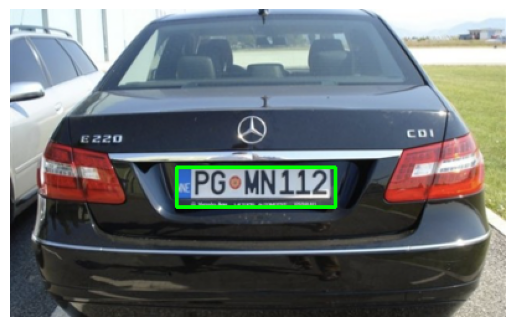

In [30]:
import os
import cv2
import matplotlib.pyplot as plt

# Directory paths
image_dir = os.getcwd() + '/datasets/car_license_plate_new/train/images'
label_dir = os.getcwd() + '/datasets/car_license_plate_new/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]
print(first_image_file)
# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')
# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [31]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [32]:
model = YOLO('yolo11n.pt')

In [33]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics 8.3.217 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d0a89d5da90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

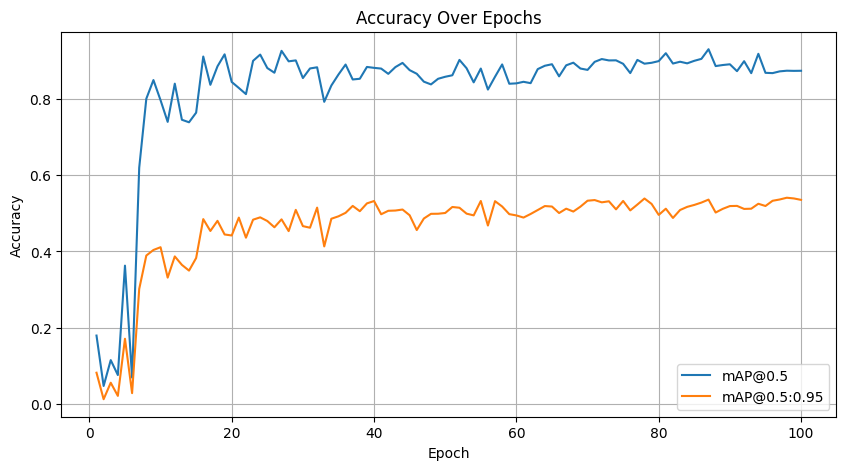

In [34]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key=find_the_number)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [41]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 43.1ms
Speed: 1.1ms preprocess, 43.1ms inference, 0.9ms postprocess per image at shape (1, 3, 160, 320)


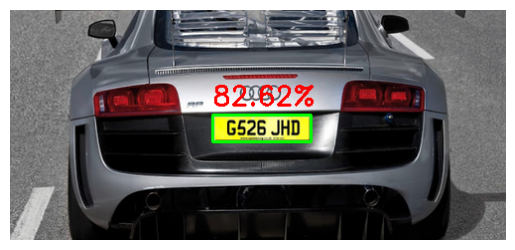

In [42]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars253.png: 192x320 1 license_plate, 33.4ms
Speed: 0.7ms preprocess, 33.4ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 320)


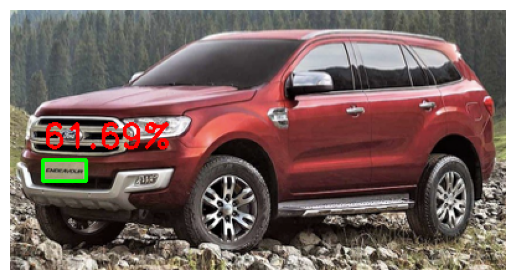

In [46]:
predict_and_plot(test.iloc[6].img_path)

## **Implementing Text Extraction**

In [74]:
!pip install easyocr -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 27.1 MB/s eta 0:00:00


In [92]:
import easyocr

def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')
    # Intialize easyocr reader
    reader = easyocr.Reader(['en'])
    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]
            # Perform OCR on the cropped image
            results = reader.readtext(roi)
            text = results[0][1] if results else ""
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars287.png: 288x320 1 license_plate, 64.5ms
Speed: 1.3ms preprocess, 64.5ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 320)
Detected text: @LZC N 5617


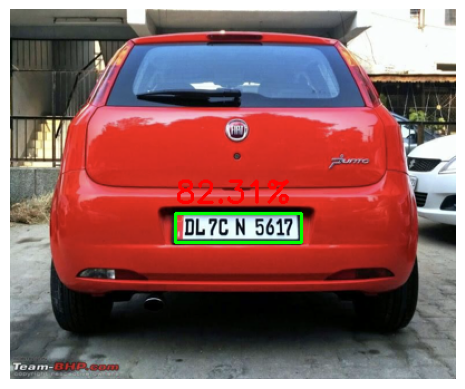

In [97]:
predict_and_plot(test.iloc[20].img_path)